# Fine-Tuning the CNN on Cancer and Subtype





In [13]:
import os
import sys
from pathlib import Path

# Prevent log clutter and potential oneDNN precision issues
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Setup paths
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from config import THYROID_PATH, MODEL_PATH, RESULTS_PATH

print(f"✅ Environment Ready. TensorFlow version: {tf.__version__}")

✅ Environment Ready. TensorFlow version: 2.20.0


In [14]:
FinalPath = Path(THYROID_PATH, 'FinalData.npy')
npz_content = np.load(FinalPath, allow_pickle=True)

# Extract and handle NaNs
X_train = np.nan_to_num(npz_content['X_cancer_train'])
y_train = npz_content['y_cancer_train']

print(f"✅ Data Loaded. X shape: {X_train.shape}, y shape: {y_train.shape}")

# Create output directories
os.makedirs("fit_history", exist_ok=True)
output_folder = Path(RESULTS_PATH, 'Final_1DCNN_Results')
output_folder.mkdir(exist_ok=True)

✅ Data Loaded. X shape: (412, 485577), y shape: (412,)


In [26]:
# Assuming you have 3 subtypes for Thyroid (adjust 'num_classes' as needed)
num_classes = len(np.unique(y_train)) 

def get_subtype_model(num_classes):
    # Use the same "Surgical Load" logic from our previous success
    model = get_uncompiled_model(reset_last_layer=False) # Get base
    
    # Extract the features before the old head
    x = model.layers[-2].output 
    
    # Add new head for multiclass subtypes
    output = keras.layers.Dense(num_classes, activation='softmax', name='subtype_output')(x)
    return keras.Model(inputs=model.input, outputs=output)

# Update Compilation
model.compile(
    loss='sparse_categorical_crossentropy', # Use this if y_train are integers (0, 1, 2...)
    optimizer=keras.optimizers.Adam(3e-5),
    metrics=['accuracy']
)

In [27]:
#Retrain Base Model for thyroid cancer classification
# Run this in a new cell or terminal if needed
!rm -rf ckpt-thyroid-cancer

In [28]:
# 1. Load Subtype Data
X_train = np.nan_to_num(npz_content['X_subtype_train']).astype('float32')
y_train = npz_content['y_subtype_train']

# 2. Check how many subtypes we are dealing with
num_classes = len(np.unique(y_train))
print(f"🎯 Training for {num_classes} subtypes.")

# 3. Initialize model (Ensure Cell 3 is updated for multiclass if needed)
model = make_or_restore_model('ckpt-thyroid-subtype', reset_last_layer=True)

# 4. Train
subtype_history = model.fit(
    X_train, 
    y_train, 
    batch_size=4, # Lower batch size to save CPU/RAM
    epochs=30, 
    callbacks=[early_stopping_cb], 
    validation_split=0.2, 
    shuffle=True
)

# 5. Save Results
os.makedirs('fit_history', exist_ok=True)
subtype_df = pd.DataFrame(subtype_history.history)
subtype_df.to_csv(os.path.join('fit_history','thyroid-subtype.csv'))

# 6. Save Model
model.save(os.path.join(MODEL_PATH, "thyroid-subtype.keras"))

print("✅ Subtype Model Training Complete.")

🎯 Training for 2 subtypes.
INFO:tensorflow:Restoring parameters from /home/Capstone_Team78/Dataset/Models/pan-cancer-leaky-relu/variables/variables
✅ MetaGraph loaded via legacy loader.
Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7823 - loss: 0.5528 - prc: 0.1552 - val_accuracy: 0.7703 - val_loss: 0.5633 - val_prc: 0.1454
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7823 - loss: 0.5527 - prc: 0.1564 - val_accuracy: 0.7703 - val_loss: 0.5632 - val_prc: 0.1433
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7823 - loss: 0.5526 - prc: 0.1596 - val_accuracy: 0.7703 - val_loss: 0.5631 - val_prc: 0.1434
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7823 - loss: 0.5524 - prc: 0.1530 - val_accuracy: 0.7703 - val_loss: 0.5630 - val_prc: 0.1437
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7823 - loss: 0.5523 - prc: 0.1539 - val_accuracy: 0.7703 - val_loss: 0.5628 - val_prc: 0.1429
✅ Subtype Model Training

In [29]:
# 1. Use the correct variable name (npz_content) and convert to float32 to save RAM
X_train_sub = np.nan_to_num(npz_content['X_subtype_train']).astype('float32')
y_train_sub = npz_content['y_subtype_train']

# 2. Check classes - if this is multiclass, the model needs to know
num_subtypes = len(np.unique(y_train_sub))
print(f"🧬 Detected {num_subtypes} thyroid subtypes. Initializing training...")

# 3. Initialize/Restore for the subtype task
# This will use the "Surgical Fix" from Cell 3 to avoid the add_slot error
model_subtype = make_or_restore_model('ckpt-thyroid-subtype', reset_last_layer=True)

# 4. Train with a safer batch size for your 1 CPU
subtype_history = model_subtype.fit(
    X_train_sub,
    y_train_sub, 
    batch_size=4, 
    epochs=30, 
    callbacks=[early_stopping_cb], 
    validation_split=0.2, 
    shuffle=True
)

# 5. Save history and the model in the stable .keras format
os.makedirs('fit_history', exist_ok=True)
subtype_df = pd.DataFrame(subtype_history.history)
subtype_df.to_csv(os.path.join('fit_history', 'thyroid-subtype.csv'))

model_subtype.save(os.path.join(MODEL_PATH, "thyroid-subtype.keras"))

print("✅ Subtype Detection Model saved successfully.")

🧬 Detected 2 thyroid subtypes. Initializing training...
INFO:tensorflow:Restoring parameters from /home/Capstone_Team78/Dataset/Models/pan-cancer-leaky-relu/variables/variables
✅ MetaGraph loaded via legacy loader.
Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7823 - loss: 0.5573 - prc: 0.1591 - val_accuracy: 0.7703 - val_loss: 0.5672 - val_prc: 0.1448
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7823 - loss: 0.5572 - prc: 0.1542 - val_accuracy: 0.7703 - val_loss: 0.5671 - val_prc: 0.1437
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7823 - loss: 0.5570 - prc: 0.1541 - val_accuracy: 0.7703 - val_loss: 0.5669 - val_prc: 0.1425
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7823 - loss: 0.5569 - prc: 0.1515 - val_accuracy: 0.7703 - val_loss: 0.5668 - val_prc: 0.1450
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7823 - loss: 0.5567 - prc: 0.1520 - val_accuracy: 0.7703 - val_loss: 0.5667 - val_prc: 0.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2,shuffle=True, stratify=y)

from collections import Counter
X_train_fill = SimpleImputer(strategy='constant').fit_transform(X_train,y_train)
X_train_over,y_train_over = over.fit_resample(X_train_fill,y_train)
X_train_under,y_train_under = under.fit_resample(X_train_over,y_train_over)

X_test_fill = SimpleImputer(strategy='constant').fit_transform(X_test,y_test)
X_test_over,y_test_over = over.fit_resample(X_test_fill,y_test)
X_test_under,y_test_under = under.fit_resample(X_test_over,y_test_over)

print(Counter(y_train))
print(Counter(y_train_under))

print(Counter(y_test))
print(Counter(y_test_under))



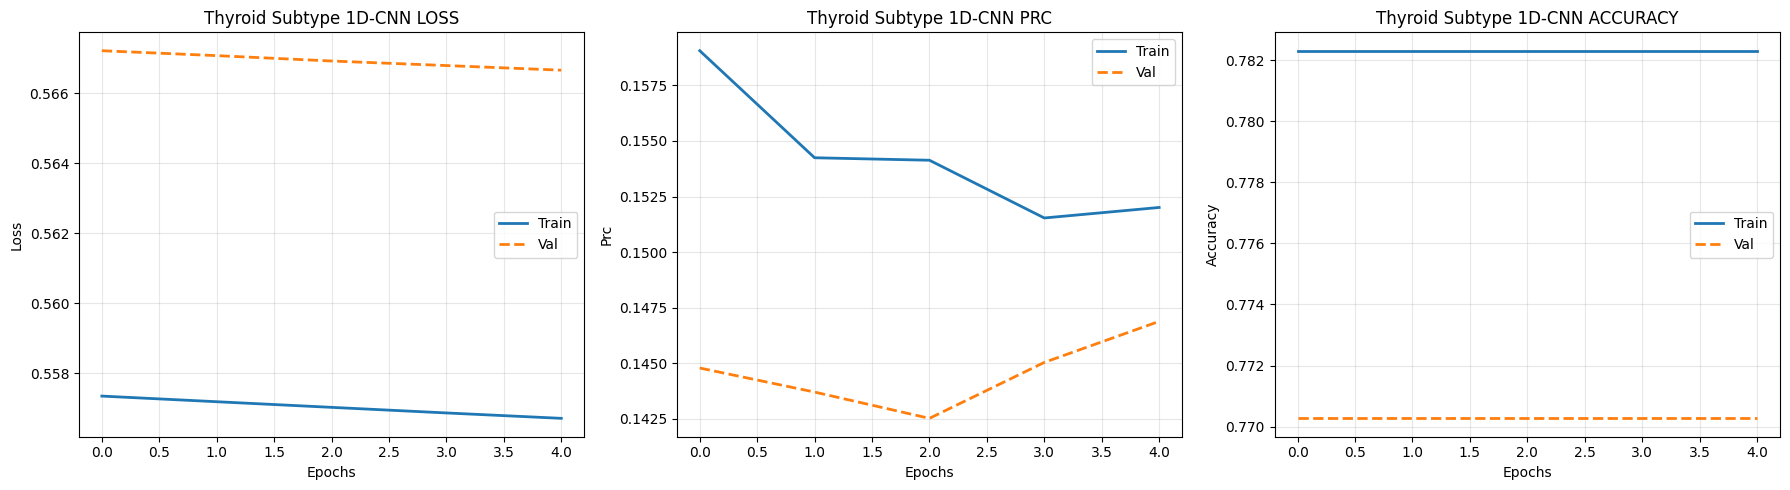

📊 Graphs saved to: /home/Capstone_Team78/Dataset/Results/Thyroid_Subtype_1D-CNN_performance.png


In [30]:
import matplotlib.pyplot as plt

def plot_metrics(history, model_name="Thyroid Model"):
    metrics = ['loss', 'prc', 'accuracy'] # Adjust based on what you have in history
    plt.figure(figsize=(18, 5))
    
    for i, metric in enumerate(metrics):
        if metric in history.history:
            plt.subplot(1, 3, i + 1)
            plt.plot(history.history[metric], label='Train', linewidth=2)
            plt.plot(history.history[f'val_{metric}'], label='Val', linestyle='--', linewidth=2)
            plt.title(f'{model_name} {metric.upper()}')
            plt.xlabel('Epochs')
            plt.ylabel(metric.capitalize())
            plt.legend()
            plt.grid(True, alpha=0.3)

    plt.tight_layout()
    
    # Save the plot to your results folder
    graph_path = os.path.join(RESULTS_PATH, f'{model_name.replace(" ", "_")}_performance.png')
    plt.savefig(graph_path)
    plt.show()
    print(f"📊 Graphs saved to: {graph_path}")

# Run the function for your subtype model
plot_metrics(subtype_history, model_name="Thyroid Subtype 1D-CNN")